Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel $\rightarrow$ Restart) and then **run all cells** (in the menubar, select Cell $\rightarrow$ Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", as well as your name and collaborators below:

In [1]:
NAME = "Tatiana Gonzalez"
COLLABORATORS = "Deeya Patel"

In [2]:
pip install pmdarima

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [3]:
import numpy as np
import pandas as pd
from scipy.stats import beta
from pmdarima import auto_arima
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
import sqlite3
import requests
from bs4 import BeautifulSoup

---

## Read Data

In [4]:
# read csv file
df = pd.read_csv('california_infectious_diseases.csv')
df.head(10)

,Disease,County,Year,Sex,Cases,Population,Rate,Lower_95__CI,Upper_95__CI
0,Anaplasmosis,Alameda,2001,Female,0.0,746596,-,0.0,0.494
1,Anaplasmosis,Alameda,2001,Male,0.0,718968,-,0.0,0.513
2,Anaplasmosis,Alameda,2001,Total,0.0,1465564,-,0.0,0.252
3,Anaplasmosis,Alameda,2002,Female,0.0,747987,-,0.0,0.493
4,Anaplasmosis,Alameda,2002,Male,0.0,720481,-,0.0,0.512
5,Anaplasmosis,Alameda,2002,Total,0.0,1468468,-,0.0,0.251
6,Anaplasmosis,Alameda,2003,Female,0.0,747441,-,0.0,0.494
7,Anaplasmosis,Alameda,2003,Male,0.0,719746,-,0.0,0.513
8,Anaplasmosis,Alameda,2003,Total,0.0,1467187,-,0.0,0.251
9,Anaplasmosis,Alameda,2004,Female,0.0,746723,-,0.0,0.494


## Data Cleaning

In [5]:
print("Missing Values Before Cleaning")
print(df.isna().sum())

Missing Values Before Cleaning
Disease            0
County             0
Year               0
Sex                0
Cases           4754
Population         0
Rate               0
Lower_95__CI    5271
Upper_95__CI    5271
dtype: int64


### Remove Rows Where County = 'California'

In [6]:
df = df[df['County'] != 'California'].reset_index(drop=True)

#### If Rate is '-', Calculate It

##### Formula: (Cases * 100,000) / Population

In [7]:
print("Sum of '-' Before: ", (df['Rate'] == "-").sum())
df.loc[df['Rate'] == '-', 'Rate'] = (df['Cases']*100000)/df['Population']
print("Sum of '-' After: ", (df['Rate'] == "-").sum())
df.head(10)

Sum of '-' Before:  146078
Sum of '-' After:  0


,Disease,County,Year,Sex,Cases,Population,Rate,Lower_95__CI,Upper_95__CI
0,Anaplasmosis,Alameda,2001,Female,0.0,746596,0.0,0.0,0.494
1,Anaplasmosis,Alameda,2001,Male,0.0,718968,0.0,0.0,0.513
2,Anaplasmosis,Alameda,2001,Total,0.0,1465564,0.0,0.0,0.252
3,Anaplasmosis,Alameda,2002,Female,0.0,747987,0.0,0.0,0.493
4,Anaplasmosis,Alameda,2002,Male,0.0,720481,0.0,0.0,0.512
5,Anaplasmosis,Alameda,2002,Total,0.0,1468468,0.0,0.0,0.251
6,Anaplasmosis,Alameda,2003,Female,0.0,747441,0.0,0.0,0.494
7,Anaplasmosis,Alameda,2003,Male,0.0,719746,0.0,0.0,0.513
8,Anaplasmosis,Alameda,2003,Total,0.0,1467187,0.0,0.0,0.251
9,Anaplasmosis,Alameda,2004,Female,0.0,746723,0.0,0.0,0.494


### Calculate the Exact Clopper-Pearson When Upper and Lower CI are NaN

In [8]:
# method used in dataset calculation to get lower and upper 95 for NaN values
def clopper_pearson_exact_method(cases, pop):
    alpha = 0.05

    # if cases = 0, lower bound should be 0 default
    if cases == 0:
        lower = 0
        upper = beta.ppf(1 - alpha / 2, 1, pop)
    elif cases == pop:
        lower = beta.ppf(alpha / 2, cases, pop - cases + 1)
        upper = 1
    else:
        lower = beta.ppf(alpha / 2, cases, pop - cases + 1)
        upper = beta.ppf(1 - alpha / 2, cases + 1, pop - cases)
    return lower * 100000, upper * 100000    

In [9]:
print("Lower Upper CI NaN Values Before Cleaning:", df['Lower_95__CI'].isna().sum(), df['Upper_95__CI'].isna().sum())

# calculate method only if col is NaN
for index, row in df.iterrows():
    lower, upper = clopper_pearson_exact_method(row['Cases'], row['Population'])
    if pd.isna(df.loc[index, 'Lower_95__CI']):
        df.loc[index, 'Lower_95__CI'] = lower
    if pd.isna(df.loc[index, 'Upper_95__CI']):
        df.loc[index, 'Upper_95__CI'] = upper

print("Lower Upper CI NaN Values After Cleaning:", df['Lower_95__CI'].isna().sum(), df['Upper_95__CI'].isna().sum())

Lower Upper CI NaN Values Before Cleaning: 5262 5262
Lower Upper CI NaN Values After Cleaning: 4754 4754


### If Rate = 'SC', Change Lower_95__CI, Lower_95__CI, Cases, and Rate

In [10]:
# suppressed when Rate = 'SC' or Cases is NaN
# protects confidentiality of individuals

df['Cases'] = df['Cases'].astype(object)
df['Rate'] = df['Rate'].astype(object)
df['Lower_95__CI'] = df['Lower_95__CI'].astype(object)
df['Upper_95__CI'] = df['Upper_95__CI'].astype(object)


df.loc[(df['Rate'] == 'SC') | (df['Cases'].isna()), 'Lower_95__CI'] = 'Suppressed'
df.loc[(df['Rate'] == 'SC') | (df['Cases'].isna()), 'Upper_95__CI'] = 'Suppressed'
df.loc[(df['Rate'] == 'SC'), 'Cases'] = 'Suppressed'
df.loc[(df['Rate'] == 'SC'), 'Rate'] = 'Suppressed'
df.loc[(df['Cases'].isna()), 'Rate'] = 'Suppressed'
df.loc[(df['Cases'].isna()), 'Cases'] = 'Suppressed'

### Removing '*' From Rates

In [11]:
df.loc[(df['Rate'] != 'Suppressed'), 'Rate'] = df.loc[df['Rate'] != 'Suppressed', 'Rate'].astype(str).str.rstrip('*').astype(float)

### Add 'Other' to Sexes

In [12]:
# add rows where Sex is 'Other'
updated_data = []
for i in range(len(df)):
    updated_data.append(df.iloc[i])
    if df.loc[i, 'Sex'] == 'Male': 
        if df.loc[i, 'Cases'] != 'Suppressed' and df.loc[i, 'Rate'] != 'Suppressed' and df.loc[i, 'Lower_95__CI'] != 'Suppressed' and df.loc[i, 'Upper_95__CI'] != 'Suppressed':
            row_for_other_sex = {'Disease': df.loc[i, 'Disease'], 'County': df.loc[i, 'County'], 'Year': df.loc[i, 'Year'], 'Sex': 'Other', 'Cases': (df.loc[i + 1, 'Cases'] - df.loc[i, 'Cases'] - df.loc[i - 1, 'Cases']), 'Population': (df.loc[i + 1, 'Population'] - df.loc[i, 'Population'] - df.loc[i - 1, 'Population']), 'Rate': None, 'Lower_95__CI': None, 'Upper_95__CI': None} 
            if row_for_other_sex['Population'] > 0:
                row_for_other_sex['Rate'] = (row_for_other_sex['Cases'] * 100000)/row_for_other_sex['Population']
                lower, upper = clopper_pearson_exact_method(row_for_other_sex['Cases'], row_for_other_sex['Population'])
                row_for_other_sex['Lower_95__CI'] = lower
                row_for_other_sex['Upper_95__CI'] = upper
            
        else:
            row_for_other_sex = {'Disease': df.loc[i, 'Disease'], 'County': df.loc[i, 'County'], 'Year': df.loc[i, 'Year'], 'Sex': 'Other', 'Cases': 'Suppressed', 'Population': (df.loc[i + 1, 'Population'] - df.loc[i, 'Population'] - df.loc[i - 1, 'Population']), 'Rate': 'Suppressed', 'Lower_95__CI': 'Suppressed', 'Upper_95__CI': 'Suppressed'} 

        # mark all relevant fields as 'Cannot Exist' if the population for Sex = Other is zero
        if row_for_other_sex['Population'] <= 0:
                row_for_other_sex['Cases'] = 'Cannot Exist'
                row_for_other_sex['Rate'] = 'Cannot Exist'
                row_for_other_sex['Lower_95__CI'] = 'Cannot Exist'
                row_for_other_sex['Upper_95__CI'] = 'Cannot Exist'    
                if row_for_other_sex['Population'] < 0:
                    row_for_other_sex['Population'] = 0
                    df.loc[i + 1, 'Population'] = df.loc[i, 'Population'] + df.loc[i - 1, 'Population']
                    df.loc[i + 1, 'Rate'] = (df.loc[i + 1, 'Cases'] * 100000)/df.loc[i + 1, 'Population']
                    lower, upper = clopper_pearson_exact_method(df.loc[i + 1, 'Cases'], df.loc[i + 1, 'Population'])
                    df.loc[i + 1, 'Lower_95__CI'] = lower
                    df.loc[i + 1, 'Upper_95__CI'] = upper
        updated_data.append(pd.Series(row_for_other_sex))

final_df = pd.DataFrame(updated_data)

### Rounding

#### Rate, Lower_95__CI, and Upper_95__CI to 3 Decimals

In [13]:
final_df.loc[(final_df['Rate'] != 'Suppressed') & (final_df['Rate'] != 'Cannot Exist'), 'Rate'] = final_df.loc[(final_df['Rate'] != 'Suppressed') & (final_df['Rate'] != 'Cannot Exist'), 'Rate'].astype(float).map(lambda x: f"{x:.3f}")
final_df.loc[(final_df['Lower_95__CI'] != 'Suppressed') & (final_df['Rate'] != 'Cannot Exist'), 'Lower_95__CI'] = final_df.loc[(final_df['Lower_95__CI'] != 'Suppressed') & (final_df['Rate'] != 'Cannot Exist'), 'Lower_95__CI'].astype(float).map(lambda x: f"{x:.3f}")
final_df.loc[(final_df['Upper_95__CI'] != 'Suppressed') & (final_df['Rate'] != 'Cannot Exist'), 'Upper_95__CI'] = final_df.loc[(final_df['Upper_95__CI'] != 'Suppressed') & (final_df['Rate'] != 'Cannot Exist'), 'Upper_95__CI'].astype(float).map(lambda x: f"{x:.3f}")
final_df.loc[(final_df['Cases'] != 'Suppressed') & (final_df['Rate'] != 'Cannot Exist'), 'Cases'] = final_df.loc[(final_df['Cases'] != 'Suppressed') & (final_df['Rate'] != 'Cannot Exist'), 'Cases'].astype(int)

### Print Final DataFrame

In [14]:
final_df.reset_index(drop=True, inplace=True)
print("Final DataFrame")
final_df.head(20)

Final DataFrame


,Disease,County,Year,Sex,Cases,Population,Rate,Lower_95__CI,Upper_95__CI
0,Anaplasmosis,Alameda,2001,Female,0,746596,0.000,0.000,0.494
1,Anaplasmosis,Alameda,2001,Male,0,718968,0.000,0.000,0.513
2,Anaplasmosis,Alameda,2001,Other,Cannot Exist,0,Cannot Exist,Cannot Exist,Cannot Exist
3,Anaplasmosis,Alameda,2001,Total,0,1465564,0.000,0.000,0.252
4,Anaplasmosis,Alameda,2002,Female,0,747987,0.000,0.000,0.493
5,Anaplasmosis,Alameda,2002,Male,0,720481,0.000,0.000,0.512
6,Anaplasmosis,Alameda,2002,Other,Cannot Exist,0,Cannot Exist,Cannot Exist,Cannot Exist
7,Anaplasmosis,Alameda,2002,Total,0,1468468,0.000,0.000,0.251
8,Anaplasmosis,Alameda,2003,Female,0,747441,0.000,0.000,0.494
9,Anaplasmosis,Alameda,2003,Male,0,719746,0.000,0.000,0.513


## Data Prediction

In [15]:
# remove str data in numerical columns
final_df['Rate'] = pd.to_numeric(final_df['Rate'], errors='coerce')
final_df['Cases'] = pd.to_numeric(final_df['Cases'], errors='coerce')
final_df['Population'] = pd.to_numeric(final_df['Population'], errors='coerce')
final_df['Lower_95__CI'] = pd.to_numeric(final_df['Lower_95__CI'], errors='coerce')
final_df['Upper_95__CI'] = pd.to_numeric(final_df['Upper_95__CI'], errors='coerce')
final_df = final_df.dropna(subset=['Rate', 'Cases', 'Population', 'Lower_95__CI', 'Upper_95__CI'])
final_df.to_csv("cleaned.csv", index=False, header=True, sep=',')

### ARIMA Model

In [ ]:
# randomly choose Disease, County, and Sex
disease = np.random.choice(final_df['Disease'].unique())
county = np.random.choice(final_df['County'].unique())
sex = np.random.choice(final_df['Sex'].unique())
print("Disease:", disease)
print("County:", county)
print("Sex:", sex)

filtered_df = final_df[(final_df['Disease'] == disease) & (final_df['County'] == county) & (final_df['Sex'] == sex)]
filtered_df.set_index(pd.to_datetime(filtered_df['Year'], format='%Y'), inplace=True)

# split data into training and test sets
train_data = filtered_df['Rate'][:int(0.8 * len(filtered_df))]
test_data = filtered_df['Rate'][int(0.8 * len(filtered_df)):]

if len(filtered_df) == 0:
    print("Cannot predict a rate for a future year due to lack of data.")
if filtered_df['Rate'].nunique() <= 5:
    prediction = [filtered_df['Rate'].mode().iloc[0]]
    print("There is little to no variability to fit the model. The prediction rate displayed is the mode.")

    # print predicted rate for 2023
    print(f'Predicted Rate for 2023: {prediction}')
elif len(filtered_df) < 10:
    print("There is not enough data to fit the model. The prediction rate displayed is the mean.")
    prediction = [filtered_df['Rate'].mean()]
    
    # print predicted rate for 2023
    print(f'Predicted Rate for 2023: {prediction}')
else:
    # fit ARIMA model
    model = auto_arima(train_data, seasonal=False, stepwise=True, suppress_warnings=True, error_action="ignore", trace=True)
    
    #print(model.summary())
    
    # rate prediction for the year 2023 (the last year reported in our collected data + 1)
    prediction = model.predict(n_periods = 1)

    # evaluate performance with mean absolute error
    mae = mean_absolute_error(test_data, model.predict(n_periods=len(test_data)))
    print(f"ARIMA Model Mean Absolute Error (MAE): {mae}")
    
    # print predicted rate for 2023
    print(f'Predicted Rate for 2023: {prediction.tolist()}')
    
if len(filtered_df) != 0:
    # plot previous rates until 2022 and the predicted rate for 2023
    plt.figure(figsize=(12,6))
    plt.plot(filtered_df.index, filtered_df['Rate'], label='Previous Data')
    plt.plot([pd.Timestamp('2023')], prediction, label=f'Prediction for 2023', color='red', marker='o')
    plt.title(f'Predicted Rate for {disease} in {county} for {sex} for 2023')
    plt.xlabel('Year')
    plt.ylabel('Rate')
    plt.legend()
    plt.show()
plt.close()

### Linear Regression Model

In [17]:
# one hot encoding
encoder = OneHotEncoder()
one_hot_encoded = encoder.fit_transform(final_df[['Disease', 'County', 'Sex']]).toarray()
one_hot_encoded_df = pd.DataFrame(one_hot_encoded, columns=encoder.get_feature_names_out(['Disease', 'County', 'Sex']))
new_df = pd.concat([final_df.reset_index(drop=True), one_hot_encoded_df], axis=1)
print(new_df)

                     Disease   County  Year     Sex  Cases  Population  Rate  \
0               Anaplasmosis  Alameda  2001  Female    0.0      746596   0.0   
1               Anaplasmosis  Alameda  2001    Male    0.0      718968   0.0   
2               Anaplasmosis  Alameda  2001   Total    0.0     1465564   0.0   
3               Anaplasmosis  Alameda  2002  Female    0.0      747987   0.0   
4               Anaplasmosis  Alameda  2002    Male    0.0      720481   0.0   
...                      ...      ...   ...     ...    ...         ...   ...   
199106  Zika Virus Infection     Yuba  2021   Total    0.0       82211   0.0   
199107  Zika Virus Infection     Yuba  2022  Female    0.0       39108   0.0   
199108  Zika Virus Infection     Yuba  2022    Male    0.0       39558   0.0   
199109  Zika Virus Infection     Yuba  2022   Other    0.0        3867   0.0   
199110  Zika Virus Infection     Yuba  2022   Total    0.0       82533   0.0   

        Lower_95__CI  Upper_95__CI  Dis

In [18]:
# create/train linear regression model
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
X = new_df[[col for col in new_df.columns if col.startswith("Disease_") or col.startswith("County_") or col.startswith("Sex_")]]
y = new_df['Rate']
X_train, X_test, y_train, y_test  = train_test_split(X, y, test_size=0.2, random_state=42)
type(X_test)
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [19]:
# create test case to predict rate given the disease, county, and sex
test_case = [
    ('Anaplasmosis', 'Alameda', 'Female'),
    ('Shigellosis', 'Mariposa', 'Male'),
    ('Cysticercosis or Taeniasis', 'Inyo', 'Other'),
    ('Yersiniosis', 'San Mateo', 'Total'),
    ('Zika Virus Infection', 'San Diego', 'Female'),
    ('Salmonellosis', 'Riverside', 'Total')
]
test_case_df = pd.DataFrame(test_case, columns=['Disease', 'County', 'Sex'])
test_case_encoded = pd.get_dummies(test_case_df, columns=['Disease', 'County', 'Sex'])
test_case_df_final = test_case_encoded.reindex(columns=X_test.columns, fill_value=0)
rate_prediction = model.predict(test_case_df_final)
print(rate_prediction)

[-3.15527344 34.54101562 11.97070312 -0.8125     -1.75488281 46.56933594]


In [20]:
# evaluate linear regression model w/ performance metrics 
y_pred = model.predict(X_test)
print(f"Mean Squared Error: {mean_squared_error(y_test, y_pred):.2f}")
print(f"R2 Score: {r2_score(y_test, y_pred):.2f}")
print("Model Coefficients:", model.coef_)
print("Model Intercept:", model.intercept_)

Mean Squared Error: 150.10
R2 Score: -1.58
Model Coefficients: [-1.23345457e+10 -1.23345457e+10 -1.23345457e+10 -1.23345457e+10
 -1.23345457e+10 -1.23345457e+10 -1.23345457e+10 -1.23345457e+10
 -1.23345457e+10 -1.23345457e+10 -1.23345457e+10 -1.23345457e+10
 -1.23345457e+10 -1.23345457e+10 -1.23345457e+10 -1.23345457e+10
 -1.23345457e+10 -1.23345457e+10 -1.23345457e+10 -1.23345457e+10
 -1.23345457e+10 -1.23345457e+10 -1.23345457e+10 -1.23345457e+10
 -1.23345457e+10 -1.23345457e+10 -1.23345457e+10 -1.23345457e+10
 -1.23345457e+10 -1.23345457e+10 -1.23345457e+10 -1.23345457e+10
 -1.23345457e+10 -1.23345457e+10 -1.23345457e+10 -1.23345457e+10
 -1.23345457e+10 -1.23345456e+10 -1.23345457e+10 -1.23345457e+10
 -1.23345457e+10 -1.23345456e+10 -1.23345457e+10 -1.23345457e+10
 -1.23345457e+10 -1.23345457e+10 -1.23345457e+10 -1.23345457e+10
 -1.23345457e+10 -1.23345457e+10 -1.23345457e+10 -1.23345457e+10
 -3.08576397e+12 -3.08576397e+12 -3.08576397e+12 -3.08576397e+12
 -3.08576397e+12 -3.0857639

In [21]:
# calculate mean rates for every unique disease, county, and sex combination
mean_rates = final_df.groupby(['Disease', 'County', 'Sex'])['Rate'].mean().reset_index()
test_case_df = pd.DataFrame(test_case, columns=['Disease', 'County', 'Sex'])
df_merged = pd.merge(test_case_df, mean_rates, on=['Disease', 'County', 'Sex'], how='left')
arr = df_merged['Rate'].to_numpy()
print(arr)

[0.01077273 0.         0.         0.73059091 0.55728571 9.08590909]


In [22]:
# evaluate baseline model and compare against linear regression model
mean_rates_train = y_train.mean()
baseline_y_pred = [mean_rates_train] * len(y_test)
print(f"Baseline Mean Squared Error: {mean_squared_error(y_test, baseline_y_pred):.2f}")
print(f"Baseline R2 Score: {r2_score(y_test, baseline_y_pred):.2f}")

Baseline Mean Squared Error: 59.58
Baseline R2 Score: -0.02


## Data Visualization

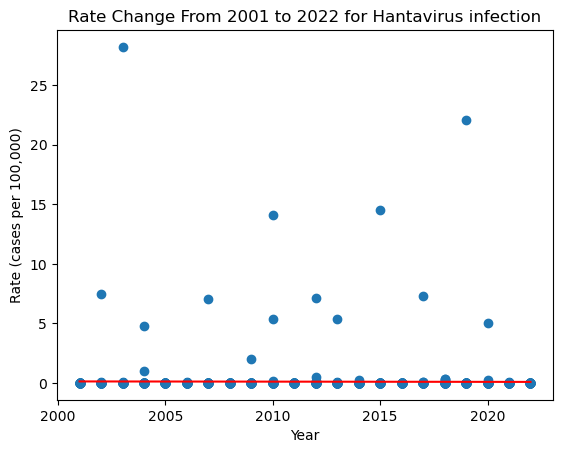

In [23]:
# plot rate change for a particular disease from 2001 - 2022
random_disease = np.random.choice(final_df['Disease'].unique())
df2 = final_df[(final_df['Sex'] == 'Total') & (final_df['Disease'] == random_disease)]
plt.scatter(df2['Year'], df2['Rate'], label='Rate Change')
plt.xlabel('Year')
plt.ylabel('Rate (cases per 100,000)')
plt.title(f'Rate Change From 2001 to 2022 for {random_disease.capitalize()}')
year = df2['Year']
rate = df2['Rate']
linear_fit = np.polyfit(year, rate, 1)
trendline = np.poly1d(linear_fit)
plt.plot(df2['Year'], trendline(df2['Year']), label='Trendline', color='red')
plt.show()

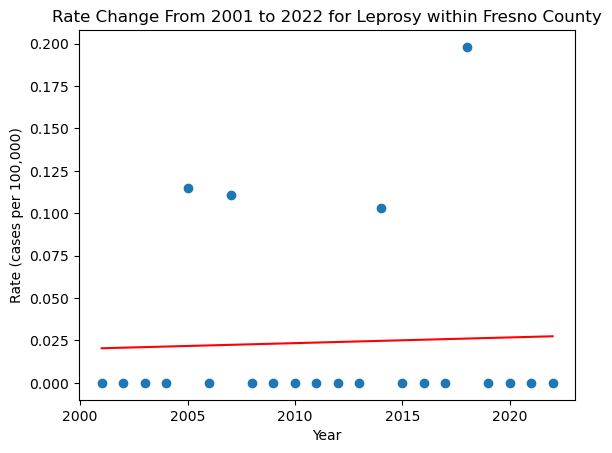

In [24]:
# plot rate change for a particular disease for a specific county from 2001 - 2022
random_disease = np.random.choice(final_df['Disease'].unique())
random_county = np.random.choice(final_df['County'].unique())
df2 = final_df[(final_df['Sex'] == 'Total') & (final_df['Disease'] == random_disease) & (final_df['County'] == random_county)]
plt.scatter(df2['Year'], df2['Rate'], label='Rate Change')
plt.xlabel('Year')
plt.ylabel('Rate (cases per 100,000)')
plt.title(f'Rate Change From 2001 to 2022 for {random_disease.capitalize()} within {random_county.capitalize()} County')
year = df2['Year']
rate = df2['Rate']
linear_fit = np.polyfit(year, rate, 1)
trendline = np.poly1d(linear_fit)
plt.plot(df2['Year'], trendline(df2['Year']), label='Trendline', color='red')
plt.show()

## Database

In [25]:
conn = sqlite3.connect('california_diseases')
cursor = conn.cursor()

cursor.execute('DROP TABLE IF EXISTS Disease')
cursor.execute('DROP TABLE IF EXISTS CountyCases')

# Disease table
cursor.execute('''
    CREATE TABLE Disease (
        name VARCHAR(25) PRIMARY KEY,
        link MEDIUMTEXT
    )
''')

# CountyCases table
cursor.execute('''
    CREATE TABLE CountyCases (
        id INTEGER PRIMARY KEY AUTOINCREMENT,
        disease VARCHAR(25),
        county VARCHAR(25) NOT NULL,
        year INTEGER NOT NULL,
        sex VARCHAR(6) NOT NULL,
        population INTEGER NOT NULL,
        cases TEXT,
        rate TEXT,
        lower_95_ci TEXT,
        upper_95_ci TEXT,
        FOREIGN KEY (disease) REFERENCES Disease (name)
    )
''')

### Describe Tables

In [26]:
# describe Disease table
cursor.execute("PRAGMA table_info(Disease);")
cursor.fetchall()

[(0, 'name', 'VARCHAR(25)', 0, None, 1), (1, 'link', 'MEDIUMTEXT', 0, None, 0)]

In [27]:
# describe CountyCases table
cursor.execute("PRAGMA table_info(CountyCases);")
cursor.fetchall()

[(0, 'id', 'INTEGER', 0, None, 1),
 (1, 'disease', 'VARCHAR(25)', 0, None, 0),
 (2, 'county', 'VARCHAR(25)', 1, None, 0),
 (3, 'year', 'INTEGER', 1, None, 0),
 (4, 'sex', 'VARCHAR(6)', 1, None, 0),
 (5, 'population', 'INTEGER', 1, None, 0),
 (6, 'cases', 'TEXT', 0, None, 0),
 (7, 'rate', 'TEXT', 0, None, 0),
 (8, 'lower_95_ci', 'TEXT', 0, None, 0),
 (9, 'upper_95_ci', 'TEXT', 0, None, 0)]

### Insert Into Disease and County Tables

In [28]:
unique_diseases = final_df['Disease'].unique()

# insert disease into Disease table
cursor.executemany('INSERT OR IGNORE INTO Disease (name) VALUES (?)', [(disease,) for disease in unique_diseases])
conn.commit()

county_cases = []
# append data from each row and col into county_cases
for _, row in final_df.iterrows():
    county_cases.append((
        row['Disease'], row['County'], row['Year'], row['Sex'], row['Population'],
        row['Cases'], row['Rate'], row['Lower_95__CI'], row['Upper_95__CI']
    ))

# insert multiple records into CountyCases table
cursor.executemany('''
    INSERT INTO CountyCases (disease, county, year, sex, population, cases, rate, lower_95_ci, upper_95_ci)
    VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?)
''', county_cases)
conn.commit()

# show first 10 records of Disease table
cursor.execute("SELECT * FROM Disease LIMIT 10")
rows = cursor.fetchall()
for row in rows:
    print(row)

('Anaplasmosis', None)
('Anthrax', None)
('Babesiosis', None)
('Botulism, Foodborne', None)
('Botulism, Other/Unknown', None)
('Botulism, Wound', None)
('Brucellosis', None)
('Campylobacteriosis', None)
('Chikungunya Virus Infection', None)
('Cholera', None)


### Ensure CountCases Table Insertions Are Correct

In [29]:
# print 10 random records of CountyCases table
cursor.execute('''SELECT * FROM CountyCases ORDER BY RANDOM() LIMIT 10''')
rows = cursor.fetchall()
for row in rows:
    print(row)

(195069, 'Yersiniosis', 'Madera', 2017, 'Total', 156077, '0.0', '0.0', '0.0', '2.363')
(192376, 'Yellow Fever', 'San Luis Obispo', 2016, 'Female', 135360, '0.0', '0.0', '0.0', '2.725')
(91322, 'Legionellosis', 'Trinity', 2009, 'Male', 7101, '0.0', '0.0', '0.0', '51.933')
(45530, 'Coccidioidomycosis', 'Solano', 2017, 'Male', 217878, '14.0', '6.426', '3.513', '10.781')
(164205, 'Spotted Fever Rickettsiosis', 'Trinity', 2012, 'Female', 6662, '0.0', '0.0', '0.0', '55.357')
(66710, 'Domoic Acid Poisoning', 'San Mateo', 2013, 'Male', 370041, '0.0', '0.0', '0.0', '0.997')
(98320, 'Leptospirosis', 'Sacramento', 2015, 'Total', 1502821, '0.0', '0.0', '0.0', '0.245')
(56163, 'Cysticercosis or Taeniasis', 'Fresno', 2004, 'Total', 860226, '0.0', '0.0', '0.0', '0.429')
(168642, 'Trichinosis', 'Yolo', 2001, 'Male', 85447, '0.0', '0.0', '0.0', '4.317')
(49562, 'Cryptosporidiosis', 'Calaveras', 2004, 'Female', 22015, '0.0', '0.0', '0.0', '16.755')


In [30]:
# print 10 random cases where cases > 0
cursor.execute('''SELECT * FROM CountyCases WHERE cases > 0 ORDER BY RANDOM() LIMIT 10''')
rows = cursor.fetchall()
for row in rows:
    print(row)

(47573, 'Creutzfeldt-Jakob Disease and other Transmissible Spongiform Encephalopathies', 'Napa', 2007, 'Male', 66424, '0.0', '0.0', '0.0', '5.553')
(167460, 'Trichinosis', 'San Luis Obispo', 2015, 'Other', 3216, '0.0', '0.0', '0.0', '114.638')
(114530, 'Paralytic Shellfish Poisoning', 'Riverside', 2012, 'Female', 1131774, '0.0', '0.0', '0.0', '0.326')
(56281, 'Cysticercosis or Taeniasis', 'Glenn', 2022, 'Total', 29212, '0.0', '0.0', '0.0', '12.627')
(188622, 'Viral Hemorrhagic Fevers (including Crimean-Congo, Ebola, Lassa, and Marburg viruses)', 'Sierra', 2017, 'Total', 3233, '0.0', '0.0', '0.0', '114.036')
(174708, 'Typhoid Fever, case', 'Modoc', 2011, 'Total', 9682, '0.0', '0.0', '0.0', '38.093')
(160174, 'Shigellosis', 'Tulare', 2014, 'Total', 459464, '5.0', '1.088', '0.353', '2.54')
(93358, 'Leprosy', 'Mendocino', 2018, 'Female', 44083, '0.0', '0.0', '0.0', '8.368')
(143658, 'Salmonellosis', 'San Luis Obispo', 2006, 'Male', 134144, '20.0', '14.909', '9.107', '23.025')
(63446, 'Deng

### Questions

#### Which 10 diseases have the highest total case count? 

In [31]:
# gets the cumulative case count for each disease, sorting by descending case count
cursor.execute('''
    SELECT disease, SUM(CAST(cases as INT)) AS sum_case 
    FROM CountyCases
    WHERE year BETWEEN 2001 AND 2022
    GROUP BY disease
    ORDER BY sum_case DESC
    LIMIT 10
''')

results = cursor.fetchall()
for row in results:
    disease, sum_case = row
    print(f"{disease}: {sum_case} cases")

Campylobacteriosis: 302710 cases
Salmonellosis: 210183 cases
Coccidioidomycosis: 192736 cases
Giardiasis: 93998 cases
Shigellosis: 88757 cases
Shiga toxin-producing E. coli (STEC) without HUS: 36188 cases
Cryptosporidiosis: 17858 cases
Legionellosis: 12370 cases
Vibrio Infection (non-Cholera): 7693 cases
Yersiniosis: 6995 cases


#### What 10 counties have the highest total number of disease cases?

In [32]:
# gets the cumulative case count for each county, sorting by descending case count
cursor.execute('''
    SELECT county, SUM(CAST(cases as INT)) AS sum_case
    FROM CountyCases
    WHERE year BETWEEN 2001 AND 2022
    GROUP BY county
    ORDER BY sum_case DESC 
    LIMIT 10
''')

results = cursor.fetchall()
for row in results:
    county, sum_county = row
    print(f"{county} County: {sum_county} cases")

Los Angeles County: 213905 cases
Kern County: 95718 cases
San Diego County: 91324 cases
Orange County: 56383 cases
Santa Clara County: 51808 cases
Alameda County: 45463 cases
San Francisco County: 43160 cases
Fresno County: 42977 cases
Riverside County: 33505 cases
San Bernardino County: 28944 cases


#### What 10 years have the highest total number of disease cases?

In [33]:
# gets the cumulative case count for each county, sorting by descending case count
cursor.execute('''
    SELECT year, SUM(CAST(cases as INT)) AS sum_case
    FROM CountyCases
    WHERE year BETWEEN 2001 AND 2022
    GROUP BY year
    ORDER BY sum_case DESC 
    LIMIT 10
''')

results = cursor.fetchall()
for row in results:
    year, sum_county = row
    print(f"{year}: {sum_county} cases")

2019: 73744 cases
2018: 68917 cases
2022: 68330 cases
2017: 64006 cases
2021: 58962 cases
2016: 54247 cases
2015: 48637 cases
2020: 47997 cases
2012: 43364 cases
2014: 42482 cases


#### What are the 10 most common diseases for females? Males? Others?

In [34]:
# gets the cumulative case count for each sex, sorting by descending case count
queries = [
    'SELECT sex, disease, SUM(CAST(cases AS INT)) AS max_cases FROM CountyCases WHERE year BETWEEN 2001 AND 2022 AND sex = "Female" GROUP BY disease ORDER BY max_cases DESC LIMIT 10',
    'SELECT sex, disease, SUM(CAST(cases AS INT)) AS max_cases FROM CountyCases WHERE year BETWEEN 2001 AND 2022 AND sex = "Male" GROUP BY disease ORDER BY max_cases DESC LIMIT 10',
    'SELECT sex, disease, SUM(CAST(cases AS INT)) AS max_cases FROM CountyCases WHERE year BETWEEN 2001 AND 2022 AND sex = "Other" GROUP BY disease ORDER BY max_cases DESC LIMIT 10',
]

for query in queries:
    cursor.execute(query)
    results = cursor.fetchall()
    for row in results:
        sex, disease, max_cases = row
        print(f"{sex}: {disease}, {max_cases} cases")
    print()

Female: Campylobacteriosis, 68508 cases
Female: Salmonellosis, 54065 cases
Female: Coccidioidomycosis, 36273 cases
Female: Shigellosis, 17863 cases
Female: Giardiasis, 17001 cases
Female: Shiga toxin-producing E. coli (STEC) without HUS, 9369 cases
Female: Cryptosporidiosis, 3668 cases
Female: Legionellosis, 2261 cases
Female: Yersiniosis, 1724 cases
Female: Vibrio Infection (non-Cholera), 1371 cases

Male: Campylobacteriosis, 80748 cases
Male: Coccidioidomycosis, 59729 cases
Male: Salmonellosis, 49518 cases
Male: Giardiasis, 29005 cases
Male: Shigellosis, 26087 cases
Male: Shiga toxin-producing E. coli (STEC) without HUS, 8414 cases
Male: Cryptosporidiosis, 5078 cases
Male: Legionellosis, 3873 cases
Male: Vibrio Infection (non-Cholera), 2426 cases
Male: Yersiniosis, 1711 cases

Other: Campylobacteriosis, 39 cases
Other: Salmonellosis, 28 cases
Other: Giardiasis, 23 cases
Other: Shiga toxin-producing E. coli (STEC) without HUS, 11 cases
Other: Coccidioidomycosis, 10 cases
Other: Shigel

#### Which 5 counties have the highest disease rate for the top 5 common diseases in 2022?

In [35]:
# CommonDisease: gets 5 diseases with the highest total cases and orders by descending
# TopCounties: ranks counties by descending rate for each disease
    # PARTITION BY: divides the rows into partitions by disease name, orders by descending rate
    # ROW_NUMBER(): assigns each row in each partition a sequential int num
# gets the top 5 counties for each disease that have the highest rates
cursor.execute('''
WITH CommonDiseases AS (
    SELECT disease, SUM(CAST(cases AS INT)) AS sum_case
    FROM CountyCases
    WHERE year BETWEEN 2001 AND 2022
    GROUP BY disease
    ORDER BY sum_case DESC
    LIMIT 5
),
TopCounties AS (
    SELECT cd.disease, cc.county, 
        MAX(CAST(cc.rate AS REAL)) AS max_rate,
        ROW_NUMBER() OVER (PARTITION BY cd.disease ORDER BY MAX(CAST(cc.rate AS REAL)) DESC) AS rank,
        cd.sum_case
    FROM (
        SELECT DISTINCT disease, county, rate
        FROM CountyCases
        WHERE year = 2022
    ) AS cc
    JOIN CommonDiseases cd ON cc.disease = cd.disease
    GROUP BY cd.disease, cc.county, cd.sum_case
)
SELECT disease, county, ROUND(max_rate, 3) AS max_rate
FROM TopCounties
WHERE rank <= 5
ORDER BY sum_case DESC, disease, rank
''')

results = cursor.fetchall()
for i, row in enumerate(results):
    disease, county, max_rate = row
    print(f"{disease}: {county} County, {max_rate:.3f}")  
    if (i + 1) % 5 == 0:
        print()

Campylobacteriosis: Imperial County, 64.303
Campylobacteriosis: Mendocino County, 58.982
Campylobacteriosis: Lake County, 49.864
Campylobacteriosis: San Francisco County, 45.542
Campylobacteriosis: Nevada County, 42.494

Salmonellosis: Imperial County, 39.807
Salmonellosis: Placer County, 25.128
Salmonellosis: San Benito County, 22.795
Salmonellosis: Tehama County, 21.620
Salmonellosis: Marin County, 21.558

Coccidioidomycosis: Kern County, 263.240
Coccidioidomycosis: Kings County, 136.470
Coccidioidomycosis: Tulare County, 70.246
Coccidioidomycosis: San Luis Obispo County, 64.808
Coccidioidomycosis: Fresno County, 58.049

Giardiasis: San Francisco County, 35.202
Giardiasis: Modoc County, 21.336
Giardiasis: Marin County, 17.981
Giardiasis: Mendocino County, 14.520
Giardiasis: Placer County, 13.151

Shigellosis: San Francisco County, 64.683
Shigellosis: Humboldt County, 34.157
Shigellosis: San Diego County, 18.258
Shigellosis: Imperial County, 17.897
Shigellosis: Los Angeles County, 15.

#### User Inquiry

In [36]:
print("Get all of the cases by year for a desired disease, county, and sex.")
inputs = ["", "", ""]
options = ['Disease', 'County', 'Sex']
for i in range(len(options)):
    print(f"List for the {options[i]}:", final_df[options[i]].unique())
    print()
    print(f'What {options[i][0].lower()}{options[i][1:]} would you like to examine?')
    inputs[i] = input('Input:').strip()

    while inputs[i] not in final_df[options[i]].unique():
        print("Your input must be in the list above.")
        inputs[i] = input('Input:').strip()
    print()

# get all available years for a specific disease
years = df[df['Disease'] == inputs[0]]['Year'].unique()

x = 'for the ' if inputs[2] != 'Total' else 'in '
s = 's' if inputs[2] != 'Total' else ''
print(f"For {inputs[0]} in {inputs[1]} County, here are the number of cases {x}{inputs[2]}{s}")

# execute query for every year
for year in years:
    
    query = f'''
        SELECT year, cases FROM CountyCases
        WHERE disease = '{inputs[0]}'
        AND county = '{inputs[1]}'
        AND sex = '{inputs[2]}'
        AND year = {year}
    '''
    cursor.execute(query)
    results = cursor.fetchall()

    for row in results:
        year, cases = row
        print(f"Year: {year}, Cases: {cases}")
        print()

Get all of the cases by year for a desired disease, county, and sex.
List for the Disease: ['Anaplasmosis' 'Anthrax' 'Babesiosis' 'Botulism, Foodborne'
 'Botulism, Other/Unknown' 'Botulism, Wound' 'Brucellosis'
 'Campylobacteriosis' 'Chikungunya Virus Infection' 'Cholera'
 'Ciguatera Fish Poisoning' 'Coccidioidomycosis'
 'Creutzfeldt-Jakob Disease and other Transmissible Spongiform Encephalopathies'
 'Cryptosporidiosis' 'Cyclosporiasis' 'Cysticercosis or Taeniasis'
 'Dengue Virus Infection' 'Domoic Acid Poisoning' 'Ehrlichiosis'
 'Flavivirus Infection of Undetermined Species' 'Giardiasis'
 'Hantavirus Infection' 'Hemolytic Uremic Syndrome'
 'Hepatitis E, acute infection' 'Legionellosis' 'Leprosy' 'Leptospirosis'
 'Listeriosis' 'Lyme Disease' 'Malaria' 'Paralytic Shellfish Poisoning'
 'Paratyphoid Fever' 'Plague, human' 'Psittacosis' 'Q Fever'
 'Rabies, human' 'Relapsing Fever' 'Salmonellosis'
 'Scombroid Fish Poisoning'
 'Shiga toxin-producing E. coli (STEC) with HUS'
 'Shiga toxin-pro

Input: Lyme Disease



List for the County: ['Alameda' 'Alpine' 'Amador' 'Butte' 'Calaveras' 'Colusa' 'Contra Costa'
 'Del Norte' 'El Dorado' 'Fresno' 'Glenn' 'Humboldt' 'Imperial' 'Inyo'
 'Kern' 'Kings' 'Lake' 'Lassen' 'Los Angeles' 'Madera' 'Marin' 'Mariposa'
 'Mendocino' 'Merced' 'Modoc' 'Mono' 'Monterey' 'Napa' 'Nevada' 'Orange'
 'Placer' 'Plumas' 'Riverside' 'Sacramento' 'San Benito' 'San Bernardino'
 'San Diego' 'San Francisco' 'San Joaquin' 'San Luis Obispo' 'San Mateo'
 'Santa Barbara' 'Santa Clara' 'Santa Cruz' 'Shasta' 'Sierra' 'Siskiyou'
 'Solano' 'Sonoma' 'Stanislaus' 'Sutter' 'Tehama' 'Trinity' 'Tulare'
 'Tuolumne' 'Ventura' 'Yolo' 'Yuba']

What county would you like to examine?


Input: San Diego



List for the Sex: ['Female' 'Male' 'Total' 'Other']

What sex would you like to examine?


Input: Male



For Lyme Disease in San Diego County, here are the number of cases for the Males
Year: 2001, Cases: 2.0

Year: 2002, Cases: 5.0

Year: 2003, Cases: 0.0

Year: 2004, Cases: 2.0

Year: 2005, Cases: 4.0

Year: 2006, Cases: 7.0

Year: 2007, Cases: 3.0

Year: 2008, Cases: 3.0

Year: 2009, Cases: 5.0

Year: 2010, Cases: 5.0

Year: 2011, Cases: 5.0

Year: 2012, Cases: 4.0

Year: 2013, Cases: 4.0

Year: 2014, Cases: 6.0

Year: 2015, Cases: 5.0

Year: 2016, Cases: 4.0

Year: 2017, Cases: 7.0

Year: 2018, Cases: 2.0

Year: 2019, Cases: 0.0

Year: 2020, Cases: 2.0

Year: 2021, Cases: 7.0

Year: 2022, Cases: 2.0



## Web Scraping

In [37]:
# search wikipedia using search results or direct page match
def search_wiki(disease):
    search_url = f"https://en.wikipedia.org/w/index.php?search={disease.replace(' ', '+')}"
    response = requests.get(search_url)
    soup = BeautifulSoup(response.text, "html.parser")

    # get first search result
    first = soup.find("li", class_="mw-search-result")
    if first:
        link = "https://en.wikipedia.org" + first.find("a")["href"]
        return link
    else:
        # see if there's a direct page match
        direct_match = soup.find("h1", class_="firstHeading")
        if direct_match and "Search results" not in direct_match.text:
            return search_url
        return None

In [ ]:
# get wiki link for every disease
unique_diseases = final_df['Disease'].unique()
for disease in unique_diseases:
    link = search_wiki(disease)
    if link:
        cursor.execute('UPDATE Disease SET link = ? WHERE name = ?', (link, disease))
conn.commit()

cursor.execute("SELECT * FROM Disease")
rows = cursor.fetchall()
for row in rows:
    print(row)

In [ ]:
# close connection
conn.close()